# Settings

In [1]:
%reset -f
%tensorflow_version 2.x 

TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os, os.path, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import re
import csv
import pathlib
import pywt
import time

plt.style.use("default")

import IPython.display as display
from PIL import Image
from scipy import ndimage, misc

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D, Input, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator


np.set_printoptions(linewidth=5000,precision=2)

In [4]:
% cd /gdrive/My\ Drive/Uni-Stra/Projet

/gdrive/My Drive/Uni-Stra/Projet


In [5]:
% ls

 annotations_trainval2017.zip      'Methods comparison.gsheet'
 clouds/                            multi_input_and_output_model.png
'<DRAFT>Image processing.ipynb'     sample_submission.csv
 Experiments_on_Image_Recognition   stuff_annotations_trainval2017.zip
 Get_Data                           train2017.zip
 imgs/                              train.csv.zip
 intel_img/                         val2017.zip


#Data

In [0]:
train_dir = 'intel_img/seg_train'
test_dir = 'intel_img/seg_test'

In [7]:
train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)
image_count = len(list(train_dir.glob('*/*.jpg')))
image_count

14034

In [8]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')])
CLASS_NAMES

array(['forest', 'buildings', 'mountain', 'street', 'sea', 'glacier'], dtype='<U9')

In [9]:
NB_CLASSES = len(CLASS_NAMES)
NB_CLASSES

6

In [10]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 50
IMG_HEIGHT = 128
IMG_WIDTH = 128
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
STEPS_PER_EPOCH = 1

train_data_gen = image_generator.flow_from_directory(directory=str(train_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 14034 images belonging to 6 classes.


In [11]:
TEST_BATCH_SIZE = 200
test_data_gen = image_generator.flow_from_directory(directory=str(test_dir),
                                                     batch_size=TEST_BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3000 images belonging to 6 classes.


In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

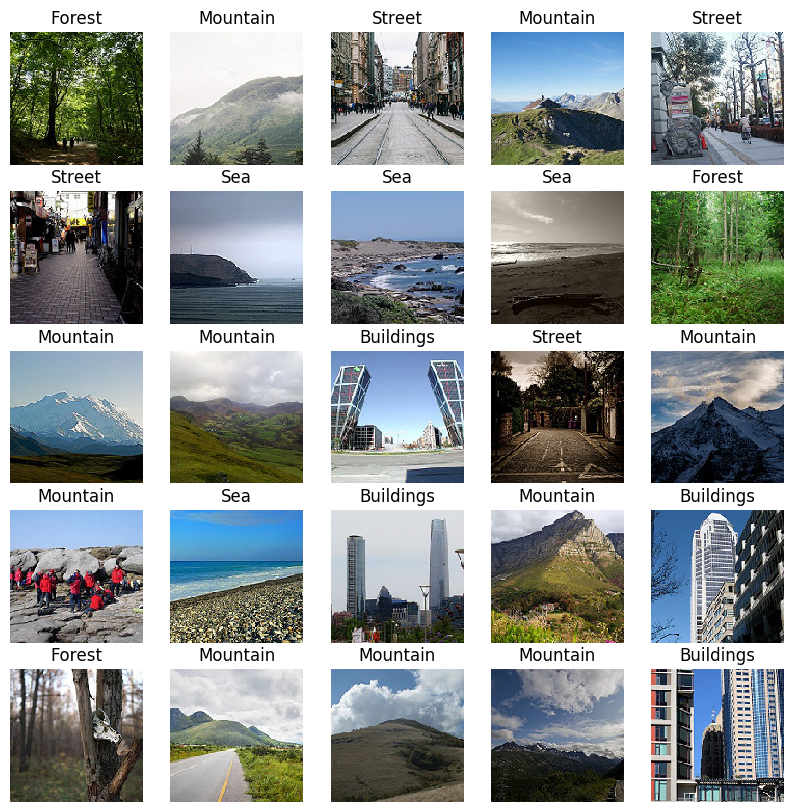

In [0]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

# Models

## Waveletize

In [0]:
def waveletize_batch(image_batch, wavelet_name='haar', mode = 'simple'):
    if mode == 'simple':
        image_batch = np.mean(image_batch, axis=-1)
        (cA, (cH, cV, cD)) = pywt.wavedec2(image_batch, wavelet_name, level=1)
        wave_batch = np.stack([cA, cH,
                            cV, cD], axis=-1)
    if mode == 'colors':
        approxs = []
        for i in range(3):
            (cA, (cH, cV, cD)) = pywt.wavedec2(image_batch[:, :, :, i], wavelet_name, level=1)
            approxs.append(cA)
        
        wave_batch = np.stack([approxs[0], approxs[1],
                               approxs[2]], axis=-1)

    return wave_batch

def waveletize_multilevel(image_batch, wavelet_name='haar', level=1):
    image_batch = np.mean(image_batch, axis=-1)

    if level == 1:
        (cA, (cH, cV, cD)) = pywt.wavedec2(image_batch, wavelet_name, level=1)
        wave_batch = np.stack([cA, cH,
                            cV, cD], axis=-1)
    else:

        decomp = pywt.wavedec2(image_batch, wavelet_name, level=level)
        wave_approx= np.stack([decomp[0], decomp[1][0], decomp[1][1],
                        decomp[1][2]], axis=-1)
        wave_batch = [wave_approx]
        for i in range(1, level):
            wave_level = np.stack([decomp[i+1][0], decomp[i+1][1],
                                    decomp[i+1][2]], axis=-1)
            wave_batch.append(wave_level)
        

    return wave_batch

In [0]:
image_batch, label_batch = next(train_data_gen)

In [14]:
decomp = pywt.wavedec2(np.mean(image_batch, axis=-1), 'haar', level=4)
print(len(decomp))
flattened = [item for sublist in decomp[1:] for item in sublist]
len(flattened)

5


12

In [15]:
image_batch.shape

(50, 128, 128, 3)

In [16]:
wave_batch = waveletize_batch(image_batch, mode='simple')
wave_batch.shape

(50, 64, 64, 4)

In [17]:
wave_batch2 = waveletize_batch(image_batch, mode='colors')
wave_batch2.shape

(50, 64, 64, 3)

In [18]:
wave_batch3 = waveletize_multilevel(image_batch, level=4)
print("Length: ", len(wave_batch3))

Length:  4


In [19]:
for i in range(len(wave_batch3)):
    print(wave_batch3[i].shape)

(50, 8, 8, 4)
(50, 16, 16, 3)
(50, 32, 32, 3)
(50, 64, 64, 3)


## (Transfer) ResNet-based models

In [0]:
base_model = tf.keras.applications.ResNet50(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')

94773248/94765736 [==============================] - 3s 0us/step


In [0]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
def transfer_model(feat_extractor, nb_classes):

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    prediction_layer = tf.keras.layers.Dense(nb_classes)

    model = tf.keras.Sequential([feat_extractor,
                                 global_average_layer,
                                 prediction_layer])

    return model

### M0

In [0]:
m0 = transfer_model(base_model, NB_CLASSES)

In [0]:
m0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 23,546,886
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
base_model.trainable = False

In [0]:
m0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
base_learning_rate = 1e-6

m0.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
loss0,accuracy0 = m0.evaluate(train_data_gen, steps = 1)

  ...
    to  
  ['...']
1/1 [==============================] - 1s 888ms/step - loss: 0.8340 - accuracy: 0.6000


In [0]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.60


In [0]:
EPOCHS = 20
losses_res_0 = []
accs_res_0 = []
durations_res_0 = []

try:

    for e in range(EPOCHS):
        starting_time = time.time()
        image_batch, label_batch = next(train_data_gen)

        history = m0.fit(x=image_batch, y=label_batch, initial_epoch=e,
                            epochs=e+1, steps_per_epoch = 10)
        
        losses_res_0.append(history.history["loss"][0])
        accs_res_0.append(history.history["accuracy"][0])
        durations_res_0.append(time.time() - starting_time)
    
except KeyboardInterrupt:
    print("Interrupted.")

Train on 50 samples
50/50 [==============================] - 2s 46ms/sample - loss: 0.7053 - accuracy: 0.7200
Train on 50 samples
Epoch 2/2
50/50 [==============================] - 0s 4ms/sample - loss: 0.6649 - accuracy: 0.7467
Train on 50 samples
Epoch 3/3
50/50 [==============================] - 0s 5ms/sample - loss: 0.7149 - accuracy: 0.7067
Train on 50 samples
Epoch 4/4
50/50 [==============================] - 0s 5ms/sample - loss: 0.6921 - accuracy: 0.7300
Train on 50 samples
Epoch 5/5
50/50 [==============================] - 0s 4ms/sample - loss: 0.6545 - accuracy: 0.7467
Train on 50 samples
Epoch 6/6
50/50 [==============================] - 0s 4ms/sample - loss: 0.6624 - accuracy: 0.7233
Train on 50 samples
Epoch 7/7
50/50 [==============================] - 0s 4ms/sample - loss: 0.6506 - accuracy: 0.7600
Train on 50 samples
Epoch 8/8
50/50 [==============================] - 0s 4ms/sample - loss: 0.6274 - accuracy: 0.7400
Train on 50 samples
Epoch 9/9
50/50 [====================

In [0]:
%%time
image_batch, label_batch = next(test_data_gen)
loss_test,accuracy_test = m0.evaluate(x=image_batch, y = label_batch)
print("Test loss: {:.2f}".format(loss_test))
print("Test accuracy: {:.2f}".format(accuracy_test))

200/200 [==============================] - 1s 5ms/sample - loss: 0.8241 - accuracy: 0.6017
Test loss: 0.82
Test accuracy: 0.60
CPU times: user 1.05 s, sys: 56.1 ms, total: 1.11 s
Wall time: 54.8 s


In [0]:
print("Total training time is {:.2f} minutes.".format(np.sum(np.array(durations_res_0))/60))

Total training time is 4.62 minutes.


### Fine tuning

In [0]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [0]:
fine_tune_at = 150
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [0]:
m0 = transfer_model(base_model, NB_CLASSES)
base_learning_rate = 1e-5

m0.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
m0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 10,002,438
Non-trainable params: 13,597,568
_________________________________________________________________


In [0]:
EPOCHS = 20
losses_res_0 = []
accs_res_0 = []
durations_res_0 = []

try:

    for e in range(EPOCHS):
        starting_time = time.time()
        image_batch, label_batch = next(train_data_gen)

        history = m0.fit(x=image_batch, y=label_batch, initial_epoch=e,
                            epochs=e+1, steps_per_epoch = 10)
        
        losses_res_0.append(history.history["loss"][0])
        accs_res_0.append(history.history["accuracy"][0])
        durations_res_0.append(time.time() - starting_time)
    
except KeyboardInterrupt:
    print("Interrupted.")

Train on 50 samples
50/50 [==============================] - 11s 215ms/sample - loss: 0.6151 - accuracy: 0.7533
Train on 50 samples
Epoch 2/2
50/50 [==============================] - 0s 7ms/sample - loss: 0.6119 - accuracy: 0.7833
Train on 50 samples
Epoch 3/3
50/50 [==============================] - 0s 7ms/sample - loss: 0.5694 - accuracy: 0.8200
Train on 50 samples
Epoch 4/4
50/50 [==============================] - 0s 7ms/sample - loss: 0.5534 - accuracy: 0.7867
Train on 50 samples
Epoch 5/5
50/50 [==============================] - 0s 7ms/sample - loss: 0.5633 - accuracy: 0.8067
Train on 50 samples
Epoch 6/6
50/50 [==============================] - 0s 7ms/sample - loss: 0.4956 - accuracy: 0.8267
Train on 50 samples
Epoch 7/7
50/50 [==============================] - 0s 7ms/sample - loss: 0.5172 - accuracy: 0.8300
Train on 50 samples
Epoch 8/8
50/50 [==============================] - 0s 7ms/sample - loss: 0.4950 - accuracy: 0.8367
Train on 50 samples
Epoch 9/9
50/50 [==================

In [0]:
%%time
image_batch, label_batch = next(test_data_gen)
loss_test,accuracy_test = m0.evaluate(x=image_batch, y = label_batch)
print("Test loss: {:.2f}".format(loss_test))
print("Test accuracy: {:.2f}".format(accuracy_test))

200/200 [==============================] - 0s 1ms/sample - loss: 0.8081 - accuracy: 0.6325
Test loss: 0.81
Test accuracy: 0.63
CPU times: user 370 ms, sys: 70.5 ms, total: 440 ms
Wall time: 1min 9s


In [0]:
print("Total training time is {:.2f} minutes.".format(np.sum(np.array(durations_res_0))/60))

Total training time is 6.08 minutes.


### M1

In [0]:
wave_batch = waveletize_batch(image_batch, mode='simple')
wave_batch.shape

(200, 64, 64, 4)

In [0]:
def transfer_model_buffed(feat_extractor, nb_classes, input_shape):

    adapt_layer = Conv2D(3, 3, padding='same', activation='relu', input_shape=input_shape)

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

    prediction_layer = tf.keras.layers.Dense(nb_classes)

    model = tf.keras.Sequential([adapt_layer, 
                                 feat_extractor,
                                 global_average_layer,
                                 prediction_layer])

    return model

In [0]:
base_model = tf.keras.applications.ResNet50(input_shape=(wave_batch.shape[1], wave_batch.shape[2], 3),
                                               include_top=False,
                                               weights='imagenet')

In [0]:
fine_tune_at = 150
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

m1 = transfer_model_buffed(base_model, NB_CLASSES, wave_batch.shape[1:])
m1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 3)         111       
_________________________________________________________________
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 23,600,117
Trainable params: 10,002,549
Non-trainable params: 13,597,568
_________________________________________________________________


In [0]:
base_learning_rate = 1e-5

m1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
image_batch, label_batch = next(train_data_gen)
wave_batch = waveletize_batch(image_batch)

loss0,accuracy0 = m1.evaluate(x=wave_batch, y=label_batch, steps = 1)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

50/50 [==============================] - 1s 25ms/sample - loss: 0.6924 - accuracy: 0.8333
initial loss: 0.69
initial accuracy: 0.83


In [0]:
EPOCHS = 20
losses_res_1 = []
accs_res_1 = []
durations_res_1 = []

try:

    for e in range(EPOCHS):
        starting_time = time.time()
        image_batch, label_batch = next(train_data_gen)
        wave_batch = waveletize_batch(image_batch)

        history = m1.fit(x=wave_batch, y=label_batch, initial_epoch=e,
                            epochs=e+1, steps_per_epoch = 10)
        
        losses_res_1.append(history.history["loss"][0])
        accs_res_1.append(history.history["accuracy"][0])
        durations_res_1.append(time.time() - starting_time)
    
except KeyboardInterrupt:
    print("Interrupted.")

Train on 50 samples
50/50 [==============================] - 4s 84ms/sample - loss: 0.7478 - accuracy: 0.6867
Train on 50 samples
Epoch 2/2
50/50 [==============================] - 0s 8ms/sample - loss: 0.7469 - accuracy: 0.7067
Train on 50 samples
Epoch 3/3
50/50 [==============================] - 0s 7ms/sample - loss: 0.6948 - accuracy: 0.6967
Train on 50 samples
Epoch 4/4
50/50 [==============================] - 0s 7ms/sample - loss: 0.7247 - accuracy: 0.6900
Train on 50 samples
Epoch 5/5
50/50 [==============================] - 0s 7ms/sample - loss: 0.6709 - accuracy: 0.7167
Train on 50 samples
Epoch 6/6
50/50 [==============================] - 0s 7ms/sample - loss: 0.6755 - accuracy: 0.7000
Train on 50 samples
Epoch 7/7
50/50 [==============================] - 0s 7ms/sample - loss: 0.6740 - accuracy: 0.7333
Train on 50 samples
Epoch 8/8
50/50 [==============================] - 0s 7ms/sample - loss: 0.6581 - accuracy: 0.7133
Train on 50 samples
Epoch 9/9
50/50 [====================

In [0]:
%%time
image_batch, label_batch = next(test_data_gen)
wave_batch = waveletize_batch(image_batch)
loss_test,accuracy_test = m1.evaluate(x=wave_batch, y = label_batch)
print("Test loss: {:.2f}".format(loss_test))
print("Test accuracy: {:.2f}".format(accuracy_test))

200/200 [==============================] - 2s 8ms/sample - loss: 0.6251 - accuracy: 0.7050
Test loss: 0.63
Test accuracy: 0.70
CPU times: user 1.67 s, sys: 329 ms, total: 2 s
Wall time: 1min 8s


In [0]:
print("Total training time is {:.2f} minutes.".format(np.sum(np.array(durations_res_1))/60))

Total training time is 5.84 minutes.


### Comparison M0 vs M1

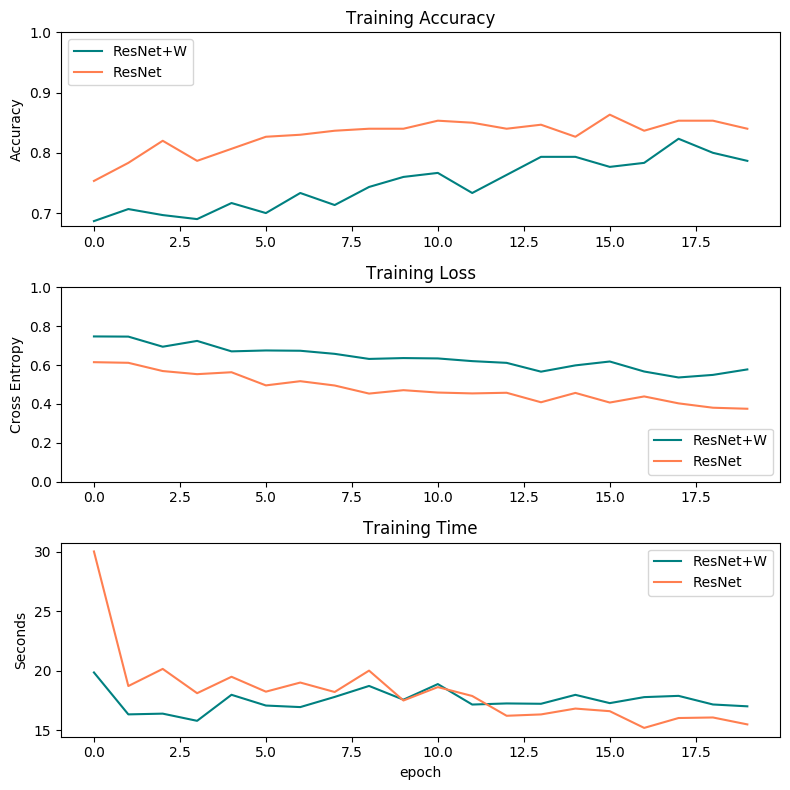

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(accs_res_1, color='teal', label='ResNet+W')
plt.plot(accs_res_0, color='coral', label='ResNet')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(3, 1, 2)
plt.plot(losses_res_1, color='teal', label='ResNet+W')
plt.plot(losses_res_0,  color='coral', label='ResNet')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')

plt.subplot(3, 1, 3)
plt.plot(durations_res_1, color='teal', label='ResNet+W')
plt.plot(durations_res_0, color='coral', label='ResNet')
plt.legend(loc='upper right')
plt.ylabel('Seconds')
plt.title('Training Time')
plt.xlabel('epoch')
plt.tight_layout();
plt.show()

## Simple CNNs (aka LeNet)

### Simple CNN

In [0]:
model0 = tf.keras.Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(image_batch.shape[1:])),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(NB_CLASSES, activation='softmax')
])

In [0]:
base_learning_rate = 0.0001

model0.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

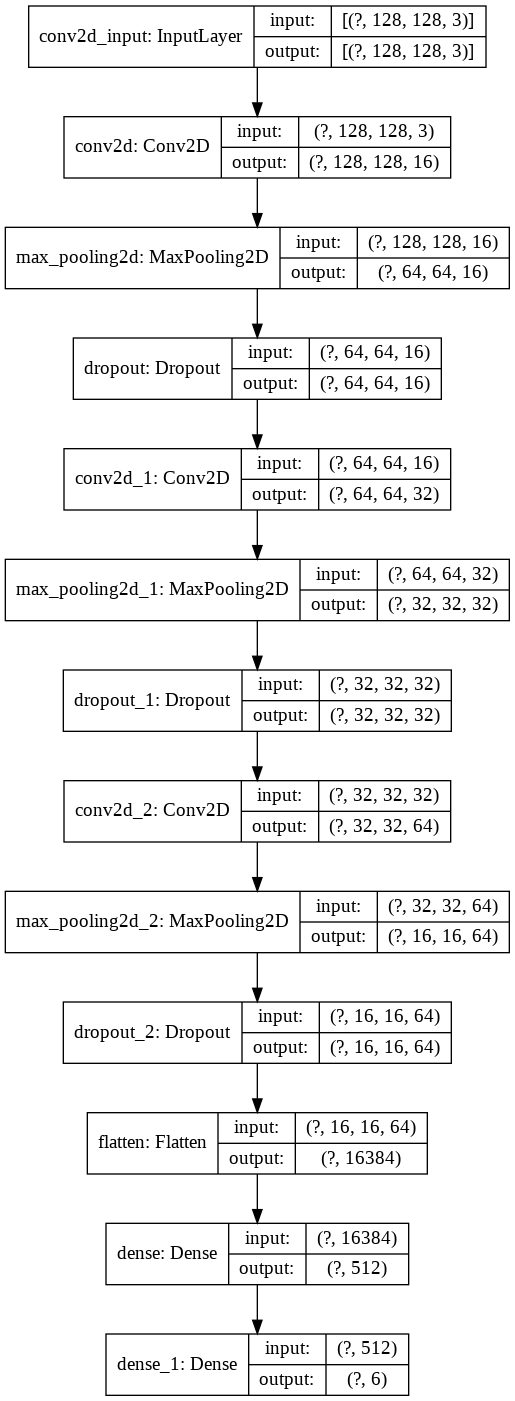

In [22]:
tf.keras.utils.plot_model(model0, 'simple_CNN.png', show_shapes=True)

In [0]:
loss0,accuracy0 = model0.evaluate(train_data_gen, steps = 1)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

  ...
    to  
  ['...']
1/1 [==============================] - 0s 343ms/step - loss: 0.7506 - accuracy: 0.8333
initial loss: 0.75
initial accuracy: 0.83


In [0]:
EPOCHS = 20
losses_0 = []
accs_0 = []
durations_0 = [] 
try:

    for e in range(EPOCHS):
        starting_time = time.time()
        history = model0.fit(train_data_gen, initial_epoch=e,
                            epochs=e+1, steps_per_epoch = 10)
        
        losses_0.append(history.history["loss"][0])
        accs_0.append(history.history["accuracy"][0])
        durations_0.append(time.time() - starting_time)
except KeyboardInterrupt:
    print("Interrupted.")

  ...
    to  
  ['...']
Train for 10 steps
10/10 [==============================] - 250s 25s/step - loss: 0.7611 - accuracy: 0.7460
  ...
    to  
  ['...']
Train for 10 steps
Epoch 2/2
10/10 [==============================] - 250s 25s/step - loss: 0.7592 - accuracy: 0.7380
  ...
    to  
  ['...']
Train for 10 steps
Epoch 3/3
10/10 [==============================] - 242s 24s/step - loss: 0.7474 - accuracy: 0.7810
  ...
    to  
  ['...']
Train for 10 steps
Epoch 4/4
10/10 [==============================] - 246s 25s/step - loss: 0.7507 - accuracy: 0.7640
  ...
    to  
  ['...']
Train for 10 steps
Epoch 5/5
10/10 [==============================] - 249s 25s/step - loss: 0.7409 - accuracy: 0.8093
  ...
    to  
  ['...']
Train for 10 steps
Epoch 6/6
10/10 [==============================] - 151s 15s/step - loss: 0.7408 - accuracy: 0.7990
  ...
    to  
  ['...']
Train for 10 steps
Epoch 7/7
10/10 [==============================] - 214s 21s/step - loss: 0.7393 - accuracy: 0.7983
  ...
   

In [0]:
%%time
image_batch, label_batch = next(test_data_gen)
loss_test,accuracy_test = model0.evaluate(x=image_batch, y = label_batch)
print("Test loss: {:.2f}".format(loss_test))
print("Test accuracy: {:.2f}".format(accuracy_test))

200/200 [==============================] - 0s 2ms/sample - loss: 0.7196 - accuracy: 0.8517
Test loss: 0.72
Test accuracy: 0.85
CPU times: user 514 ms, sys: 114 ms, total: 628 ms
Wall time: 1min 58s


In [0]:
print("Total training time is {:.2f} minutes.".format(np.sum(np.array(durations_0))/60))

Total training time is 70.38 minutes.


### Simple CNN + wavelet augmentation

In [0]:
model1 = tf.keras.Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(wave_batch.shape[1:])),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(NB_CLASSES, activation='softmax')
])

In [24]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 16)        592       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)       

In [0]:
base_learning_rate = 0.0001

model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

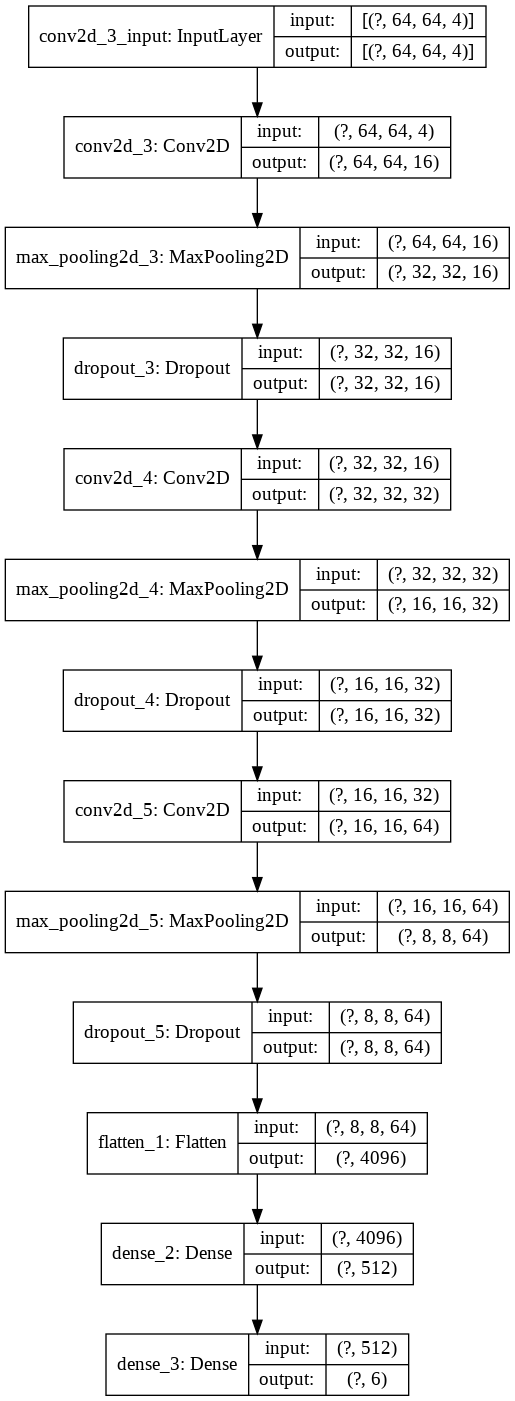

In [26]:
tf.keras.utils.plot_model(model1, 'CNN+WT.png', show_shapes=True)

In [0]:
image_batch, label_batch = next(train_data_gen)
wave_batch = waveletize_batch(image_batch)

loss0,accuracy0 = model1.evaluate(x=wave_batch, y=label_batch, steps = 1)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/1 [==============================] - 7s 7s/step - loss: 0.7521 - acc: 0.8333
initial loss: 0.75
initial accuracy: 0.83


In [0]:
EPOCHS = 20
losses = []
accs = []
durations = []

try:

    for e in range(EPOCHS):
        starting_time = time.time()
        image_batch, label_batch = next(train_data_gen)
        wave_batch = waveletize_batch(image_batch)

        history = model1.fit(x=wave_batch, y=label_batch, initial_epoch=e,
                            epochs=e+1, steps_per_epoch = 10)
        
        losses.append(history.history["loss"][0])
        accs.append(history.history["accuracy"][0])
        durations.append(time.time() - starting_time)
    
except KeyboardInterrupt:
    print("Interrupted.")

Train on 10 samples
10/10 [==============================] - 0s 43ms/step - loss: 0.7397 - acc: 0.8190


KeyError: ignored

In [0]:
%%time
image_batch, label_batch = next(test_data_gen)
wave_batch = waveletize_batch(image_batch)
loss_test,accuracy_test = model1.evaluate(x=wave_batch, y = label_batch)
print("Test loss: {:.2f}".format(loss_test))
print("Test accuracy: {:.2f}".format(accuracy_test))

In [0]:
print("Total training time is {:.2f} minutes.".format(np.sum(np.array(durations))/60))

Total training time is 0.00 minutes.


### Comparison with simple CNN

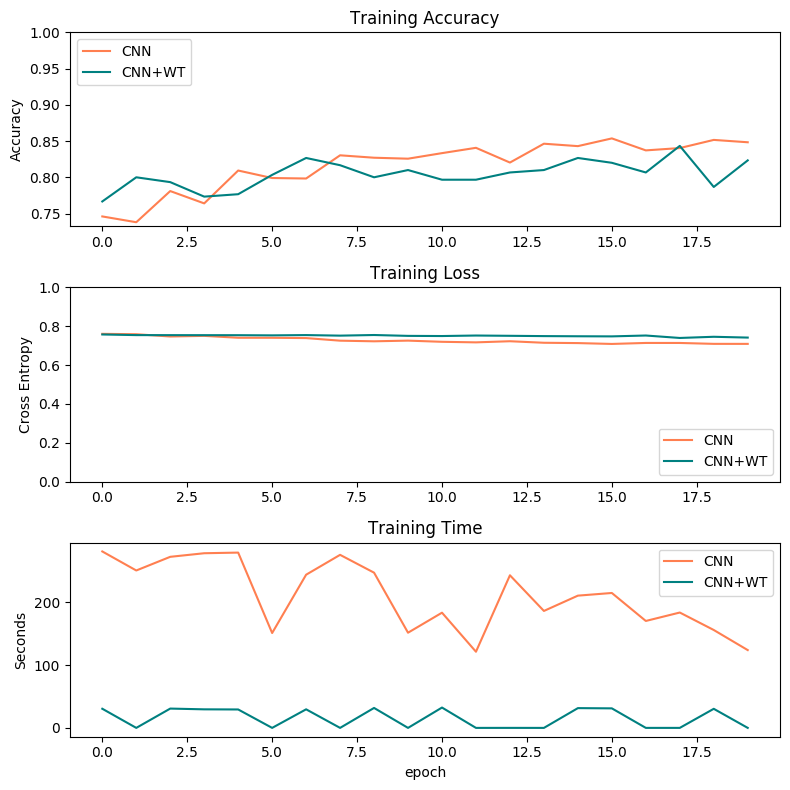

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(accs_0, color = 'coral', label='CNN')
plt.plot(accs, color = 'teal', label='CNN+WT')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(3, 1, 2)
plt.plot(losses_0, color = 'coral', label='CNN')
plt.plot(losses, color = 'teal', label='CNN+WT')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')

plt.subplot(3, 1, 3)
plt.plot(durations_0, color = 'coral', label='CNN')
plt.plot(durations, color = 'teal', label='CNN+WT')
plt.legend(loc='upper right')
plt.ylabel('Seconds')
plt.title('Training Time')
plt.xlabel('epoch')
plt.tight_layout();
plt.show()

### CNN + Wavelet augmentation 2

In [0]:
wave_batch = waveletize_batch(image_batch, mode='colors')
wave_batch.shape

(200, 64, 64, 3)

In [0]:
model2 = tf.keras.Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(wave_batch.shape[1:])),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(NB_CLASSES, activation='softmax')
])

In [0]:
base_learning_rate = 0.0001

model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [0]:
image_batch, label_batch = next(train_data_gen)
wave_batch = waveletize_batch(image_batch, mode='colors')

loss0,accuracy0 = model2.evaluate(x=wave_batch, y=label_batch, steps = 1)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

50/50 [==============================] - 0s 2ms/sample - loss: 0.7525 - accuracy: 0.8333
initial loss: 0.75
initial accuracy: 0.83


In [0]:
EPOCHS = 20
losses_c = []
accs_c = []
durations_c = []

try:

    for e in range(EPOCHS):
        starting_time = time.time()
        image_batch, label_batch = next(train_data_gen)
        wave_batch = waveletize_batch(image_batch, mode='colors')

        history = model2.fit(x=wave_batch, y=label_batch, initial_epoch=e,
                            epochs=e+1, steps_per_epoch = 10)
        
        losses_c.append(history.history["loss"][0])
        accs_c.append(history.history["accuracy"][0])
        durations_c.append(time.time() - starting_time)
    
except KeyboardInterrupt:
    print("Interrupted.")

Train on 50 samples
50/50 [==============================] - 1s 13ms/sample - loss: 0.7557 - accuracy: 0.8133
Train on 50 samples
Epoch 2/2
50/50 [==============================] - 0s 1ms/sample - loss: 0.7524 - accuracy: 0.8200
Train on 50 samples
Epoch 3/3
50/50 [==============================] - 0s 989us/sample - loss: 0.7514 - accuracy: 0.8367
Train on 50 samples
Epoch 4/4
50/50 [==============================] - 0s 1ms/sample - loss: 0.7475 - accuracy: 0.8300
Train on 50 samples
Epoch 5/5
50/50 [==============================] - 0s 998us/sample - loss: 0.7521 - accuracy: 0.7933
Train on 50 samples
Epoch 6/6
50/50 [==============================] - 0s 986us/sample - loss: 0.7508 - accuracy: 0.8133
Train on 50 samples
Epoch 7/7
50/50 [==============================] - 0s 1ms/sample - loss: 0.7436 - accuracy: 0.8200
Train on 50 samples
Epoch 8/8
50/50 [==============================] - 0s 1ms/sample - loss: 0.7498 - accuracy: 0.8267
Train on 50 samples
Epoch 9/9
50/50 [==============

In [0]:
%%time
image_batch, label_batch = next(test_data_gen)
wave_batch = waveletize_batch(image_batch, mode='colors')
loss_test,accuracy_test = model2.evaluate(x=wave_batch, y = label_batch)
print("Test loss: {:.2f}".format(loss_test))
print("Test accuracy: {:.2f}".format(accuracy_test))

200/200 [==============================] - 0s 162us/sample - loss: 0.7412 - accuracy: 0.8458
Test loss: 0.74
Test accuracy: 0.85
CPU times: user 423 ms, sys: 62.1 ms, total: 485 ms
Wall time: 2min


In [0]:
print("Total training time is {:.2f} minutes.".format(np.sum(np.array(durations_c))/60))

Total training time is 4.74 minutes.


### Comparison of Wavelet Transforms

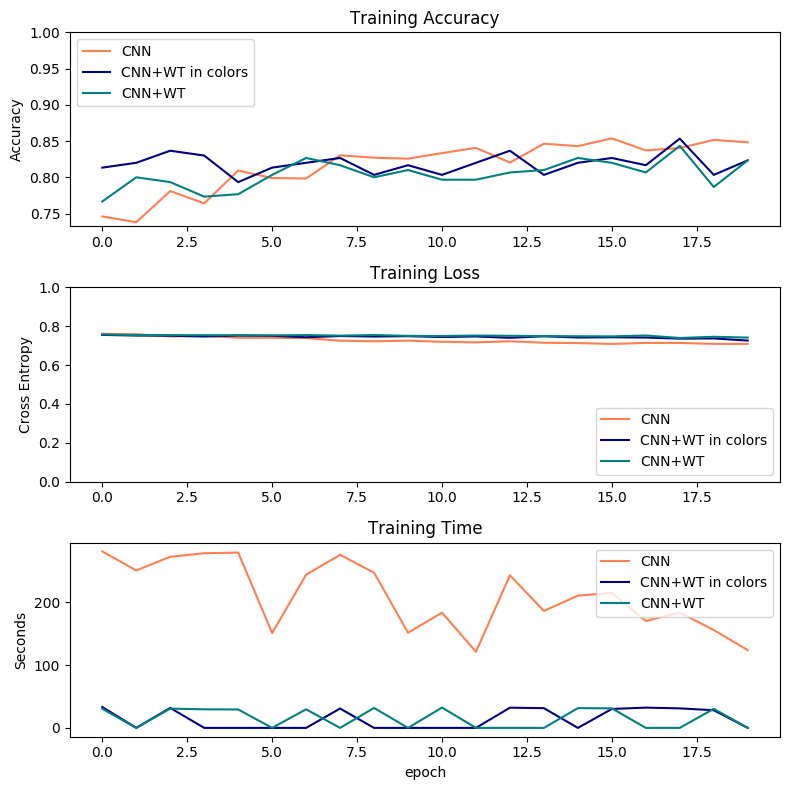

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(accs_0, color = 'coral', label='CNN')
plt.plot(accs_c, color = 'navy', label='CNN+WT in colors')
plt.plot(accs, color = 'teal', label='CNN+WT')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(3, 1, 2)
plt.plot(losses_0, color = 'coral', label='CNN')
plt.plot(losses_c, color = 'navy', label='CNN+WT in colors')
plt.plot(losses, color = 'teal', label='CNN+WT')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')

plt.subplot(3, 1, 3)
plt.plot(durations_0, color = 'coral', label='CNN')
plt.plot(durations_c, color = 'navy', label='CNN+WT in colors')
plt.plot(durations, color = 'teal', label='CNN+WT')
plt.legend(loc='upper right')
plt.ylabel('Seconds')
plt.title('Training Time')
plt.xlabel('epoch')
plt.tight_layout();
plt.show()

## Multi-level, multi-input CNNs lvl 4

In [0]:
def cyborg_lvl_4(nb_classes, input_shapes):

    # inputs: original_image &
    # wavelet approximation & details up to level 4
    img_input = Input(shape=input_shapes[0], name='img')  
    approx = Input(shape=input_shapes[-1], name='approx')  
    detail_Lvl_3 = Input(shape=input_shapes[3], name='Lvl3')  
    detail_Lvl_2 = Input(shape=input_shapes[2], name='Lvl2') 
    detail_Lvl_1 = Input(shape=input_shapes[1], name='Lvl1') 

    # model
    Y = Conv2D(5, 3, padding='same', activation='relu')(img_input)
    Y = MaxPooling2D()(Y)

    # merge with detail_lvl_1
    Y = concatenate([Y, detail_Lvl_1])

    Y = Conv2D(13, 3, padding='same', activation='relu')(Y)
    Y = MaxPooling2D()(Y)
    Y = Dropout(0.25)(Y)

    # merge with detail_lvl_2
    Y = concatenate([Y, detail_Lvl_2])

    Y = Conv2D(13, 3, padding='same', activation='relu')(Y)
    Y = MaxPooling2D()(Y)
    Y = Dropout(0.25)(Y)

    # merge with detail_lvl_3
    Y = concatenate([Y, detail_Lvl_3])

    Y = Conv2D(28, 3, padding='same', activation='relu')(Y)
    Y = MaxPooling2D()(Y)
    Y = Dropout(0.25)(Y)

    # merge with approx
    Y = concatenate([Y, approx])

    Y = Conv2D(64, 3, padding='same', activation='relu')(Y)
    Y = MaxPooling2D()(Y)
    Y = Dropout(0.25)(Y)

    Y = Flatten()(Y)
    Y = Dense(512, activation='relu')(Y)
    Y = Dense(nb_classes, activation='softmax')(Y)

    model = tf.keras.Model( inputs=[img_input, approx, detail_Lvl_3, 
                                detail_Lvl_2, detail_Lvl_1],
                        outputs = [Y])

    return model

In [0]:
image_batch, label_batch = next(train_data_gen)

In [0]:
lvl = 4
inps = [image_batch]
inp_shapes = [image_batch.shape[1:]]
wave_batch = waveletize_multilevel(image_batch, level=lvl)
for i in range(1, lvl+1):
    print(wave_batch[lvl-i].shape)
    inp_shapes.append(wave_batch[lvl-i].shape[1:])
    inps.append(wave_batch[lvl-i])

(50, 64, 64, 3)
(50, 32, 32, 3)
(50, 16, 16, 3)
(50, 8, 8, 4)


In [0]:
for i in range(len(inp_shapes)):
    print(inp_shapes[i])

(128, 128, 3)
(64, 64, 3)
(32, 32, 3)
(16, 16, 3)
(8, 8, 4)


In [0]:
mc = cyborg_lvl_4(NB_CLASSES, inp_shapes)
mc.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 5)  140         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 5)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
Lvl1 (InputLayer)               [(None, 64, 64, 3)]  0                                            
______________________________________________________________________________________________

In [0]:
base_learning_rate = 0.000001

mc.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

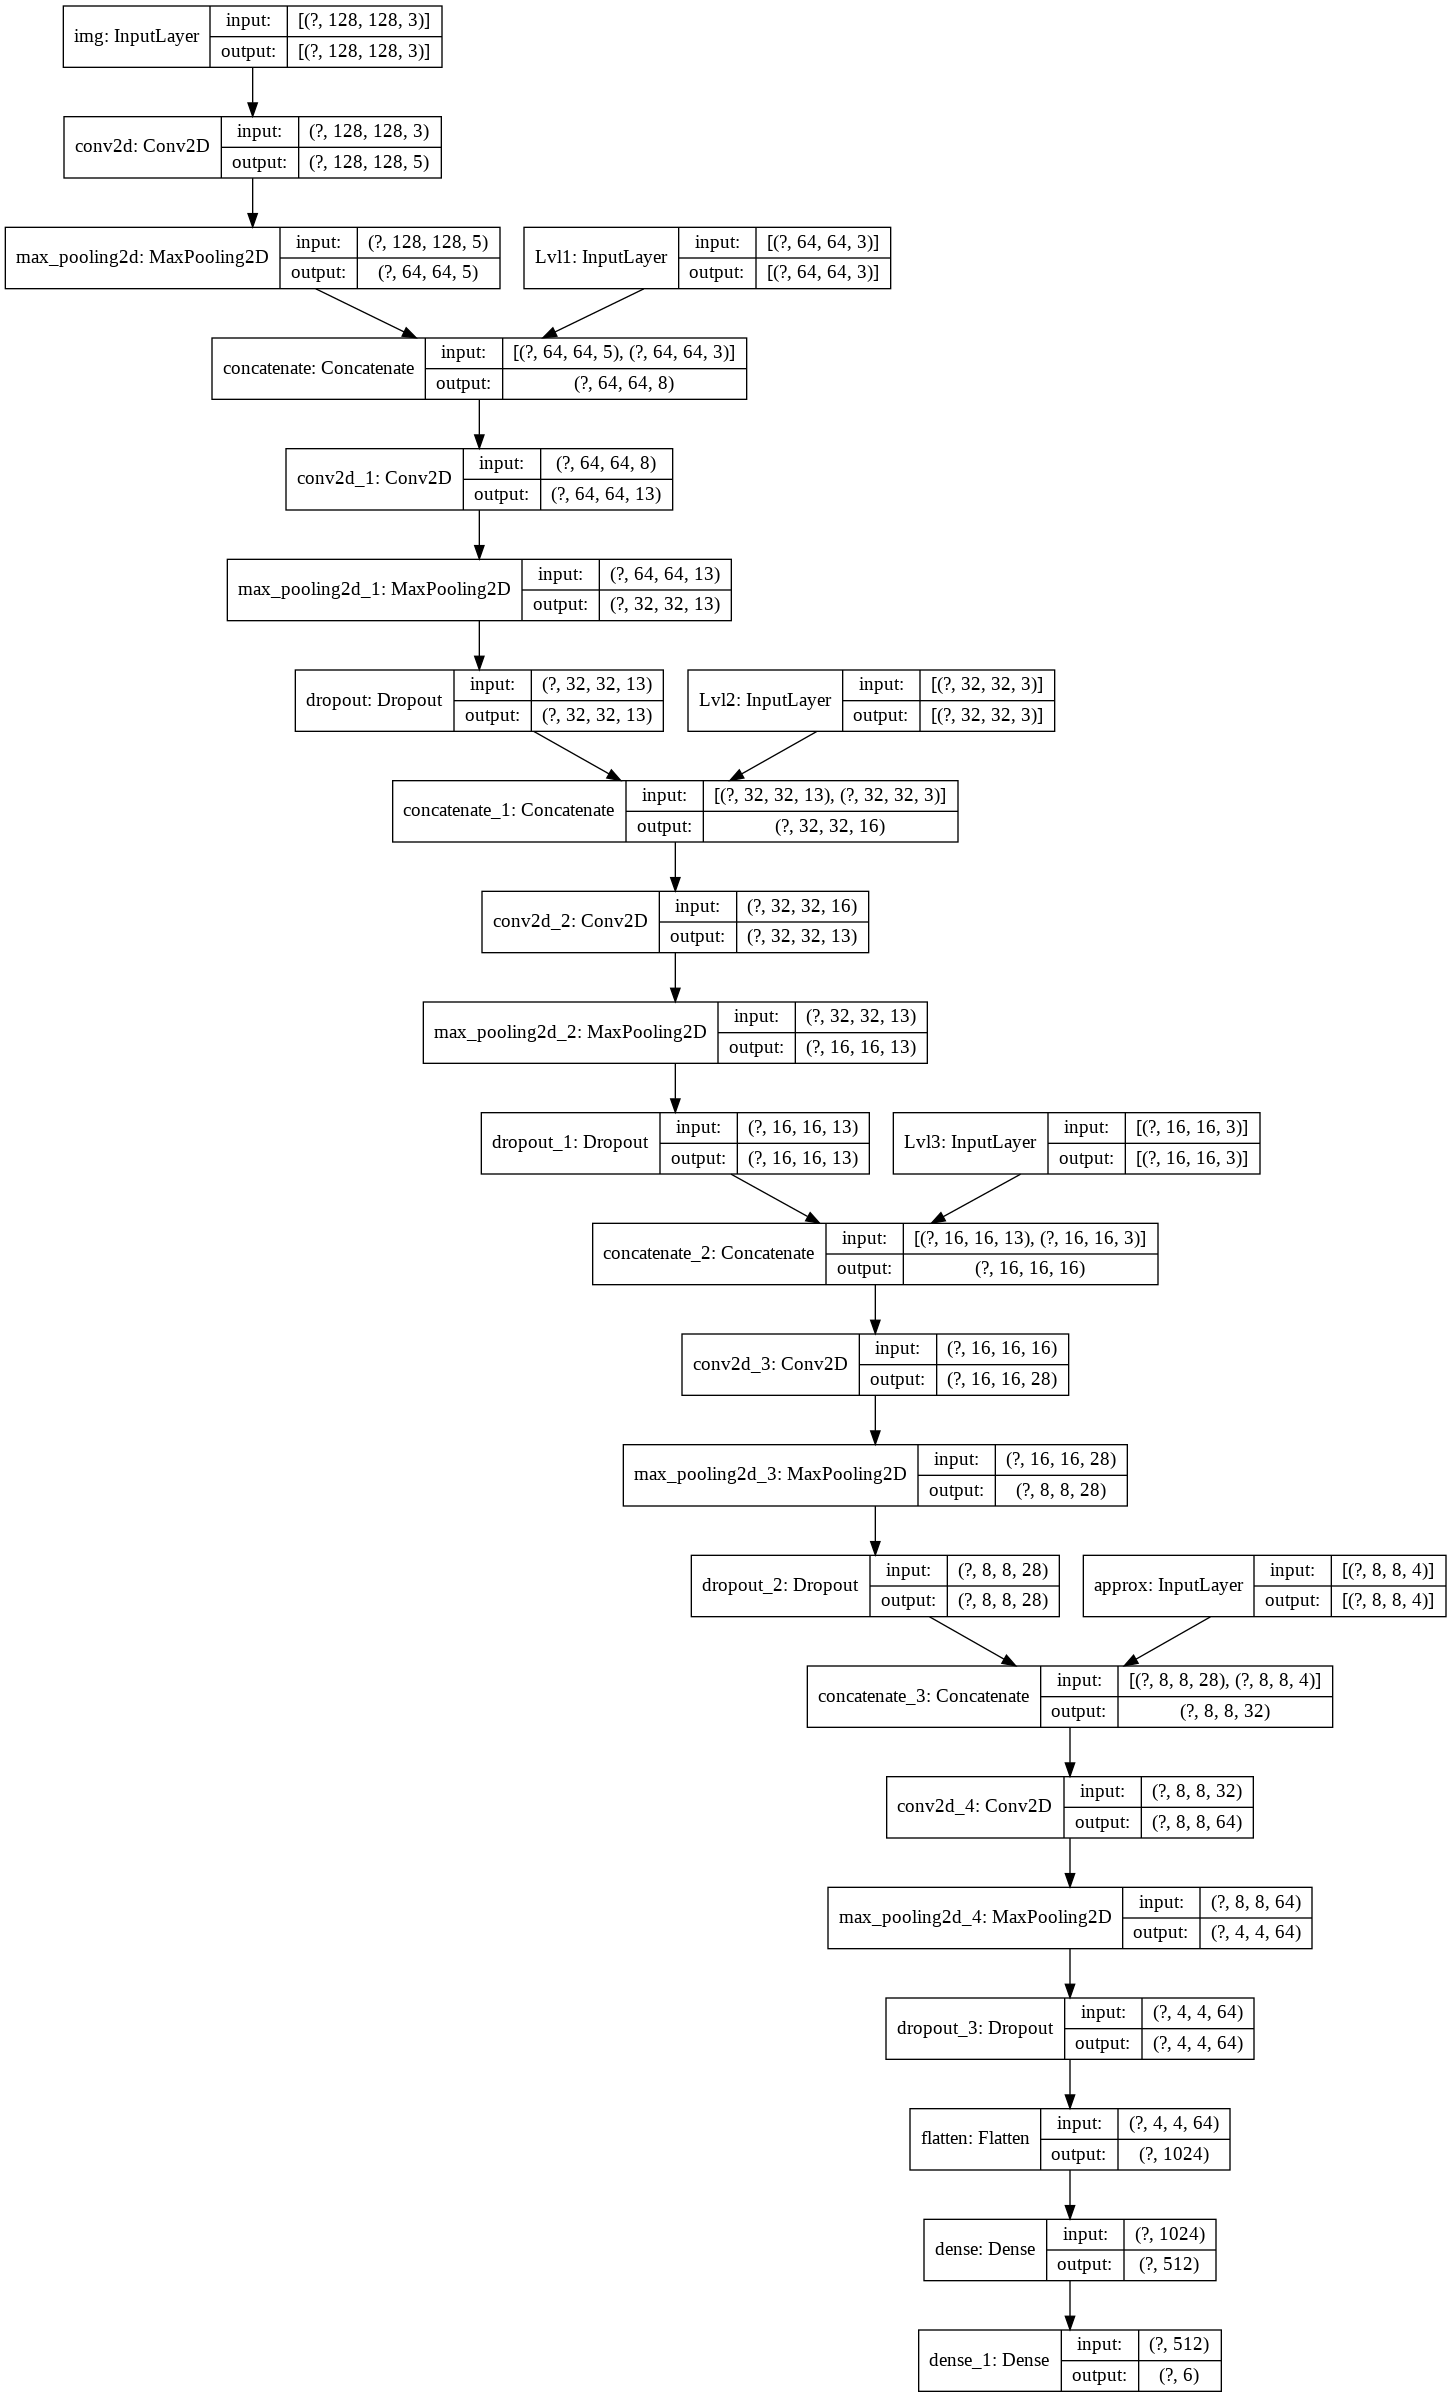

In [0]:
tf.keras.utils.plot_model(mc, 'multi_input_and_output_model.png', show_shapes=True)

In [0]:
image_batch, label_batch = next(train_data_gen)
wave_batch = waveletize_multilevel(image_batch, level=lvl)
inps = [image_batch]
for i in range(1, lvl+1):
    inps.append(wave_batch[lvl-i])

loss0,accuracy0 = mc.evaluate(x={'img': inps[0], 'approx': inps[-1], 
 'Lvl1': inps[1], 'Lvl2': inps[2], 'Lvl3': inps[3]}, y=label_batch, steps = 1)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

50/50 [==============================] - 7s 139ms/sample - loss: 0.7630 - accuracy: 0.7333
initial loss: 0.76
initial accuracy: 0.73


In [0]:
EPOCHS = 20
losses_m = []
accs_m = []
durations_m = []

In [0]:
try:

    for e in range(EPOCHS):
        starting_time = time.time()
        image_batch, label_batch = next(train_data_gen)
        wave_batch = waveletize_multilevel(image_batch, level=lvl)
        inps = [image_batch]
        for i in range(1, lvl+1):
            inps.append(wave_batch[lvl-i])

        history = mc.fit(x={'img': inps[0], 'approx': inps[-1], 
                            'Lvl1': inps[1], 'Lvl2': inps[2], 'Lvl3': inps[3]}, 
                            y=label_batch, initial_epoch=e,
                            epochs=e+1, steps_per_epoch = 10)
        
        losses_m.append(history.history["loss"][0])
        accs_m.append(history.history["accuracy"][0])
        durations_m.append(time.time() - starting_time)
    
except KeyboardInterrupt:
    print("Interrupted.")

Train on 50 samples
50/50 [==============================] - 1s 22ms/sample - loss: 0.7614 - accuracy: 0.7500
Train on 50 samples
Epoch 2/2
50/50 [==============================] - 0s 2ms/sample - loss: 0.7623 - accuracy: 0.7467
Train on 50 samples
Epoch 3/3
50/50 [==============================] - 0s 1ms/sample - loss: 0.7523 - accuracy: 0.8000
Train on 50 samples
Epoch 4/4
50/50 [==============================] - 0s 1ms/sample - loss: 0.7616 - accuracy: 0.7667
Train on 50 samples
Epoch 5/5
50/50 [==============================] - 0s 2ms/sample - loss: 0.7649 - accuracy: 0.7633
Train on 50 samples
Epoch 6/6
50/50 [==============================] - 0s 2ms/sample - loss: 0.7616 - accuracy: 0.7767
Train on 50 samples
Epoch 7/7
50/50 [==============================] - 0s 2ms/sample - loss: 0.7600 - accuracy: 0.7567
Train on 50 samples
Epoch 8/8
50/50 [==============================] - 0s 1ms/sample - loss: 0.7579 - accuracy: 0.7767
Train on 50 samples
Epoch 9/9
50/50 [====================

In [0]:
%%time
image_batch, label_batch = next(test_data_gen)
wave_batch = waveletize_multilevel(image_batch, level=lvl)
inps = [image_batch]
for i in range(1, lvl+1):
    inps.append(wave_batch[lvl-i])

loss_test,accuracy_test = mc.evaluate(x={'img': inps[0], 'approx': inps[-1], 
 'Lvl1': inps[1], 'Lvl2': inps[2], 'Lvl3': inps[3]}, y=label_batch)
print("Test loss: {:.2f}".format(loss_test))
print("Test accuracy: {:.2f}".format(accuracy_test))

200/200 [==============================] - 0s 2ms/sample - loss: 0.7590 - accuracy: 0.8225
Test loss: 0.76
Test accuracy: 0.82
CPU times: user 606 ms, sys: 118 ms, total: 724 ms
Wall time: 41.4 s


In [0]:
print("Total training time is {:.2f} minutes.".format(np.sum(np.array(durations_m))/60))

Total training time is 3.65 minutes.


### Comparison with Multilevel Wavelet transform

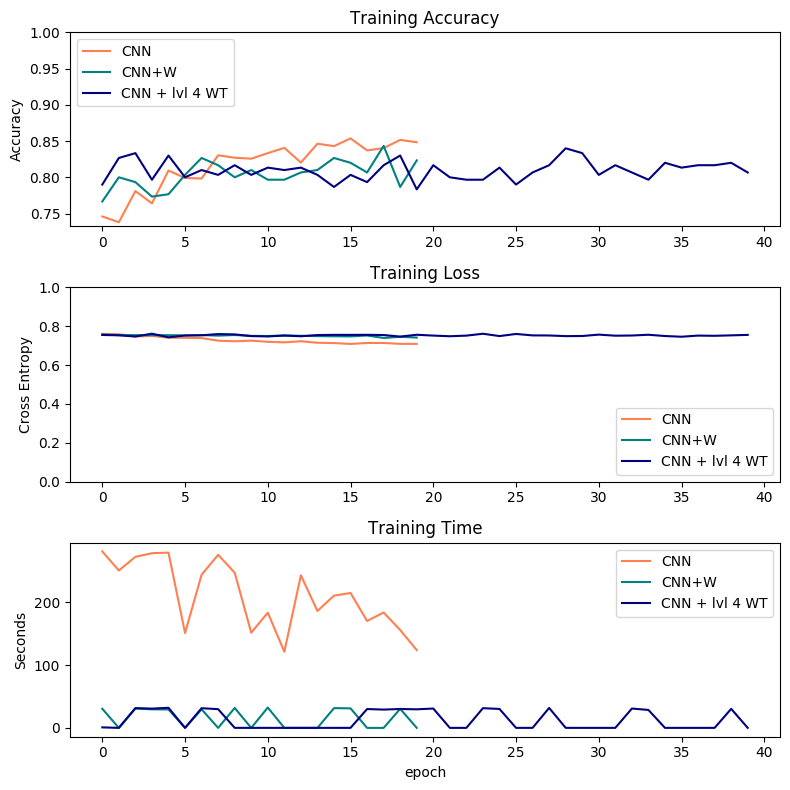

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(accs_0, color = 'coral', label='CNN')
plt.plot(accs, color = 'teal', label='CNN+W')
plt.plot(accs_m, color = 'navy', label='CNN + lvl 4 WT')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(3, 1, 2)
plt.plot(losses_0, color = 'coral', label='CNN')
plt.plot(losses, color = 'teal', label='CNN+W')
plt.plot(losses_m, color = 'navy', label='CNN + lvl 4 WT')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')

plt.subplot(3, 1, 3)
plt.plot(durations_0, color = 'coral', label='CNN')
plt.plot(durations, color = 'teal', label='CNN+W')
plt.plot(durations_m, color = 'navy', label='CNN + lvl 4 WT')
plt.legend(loc='upper right')
plt.ylabel('Seconds')
plt.title('Training Time')
plt.xlabel('epoch')
plt.tight_layout();
plt.show()

## Multi-level, multi-input CNNs lvl 2

In [0]:
def cyborg_lvl_2(nb_classes, input_shapes):

    # inputs: original_image &
    # wavelet approximation & details up to level 4
    img_input = Input(shape=input_shapes[0], name='img')  
    approx = Input(shape=input_shapes[-1], name='approx')  
    detail_Lvl_1 = Input(shape=input_shapes[1], name='Lvl1') 

    # model
    Y = Conv2D(13, 3, padding='same', activation='relu')(img_input)
    Y = MaxPooling2D()(Y)
    Y = Dropout(0.13)(Y)

    # merge with detail_lvl_1
    Y = concatenate([Y, detail_Lvl_1])

    Y = Conv2D(28, 3, padding='same', activation='relu')(Y)
    Y = MaxPooling2D()(Y)
    Y = Dropout(0.25)(Y)

     # merge with approx
    Y = concatenate([Y, approx])

    Y = Conv2D(64, 3, padding='same', activation='relu')(Y)
    Y = MaxPooling2D()(Y)
    Y = Dropout(0.5)(Y)

    Y = Flatten()(Y)
    Y = Dense(512, activation='relu')(Y)
    Y = Dense(nb_classes, activation='softmax')(Y)

    model = tf.keras.Model( inputs=[img_input, approx, detail_Lvl_1],
                        outputs = [Y])

    return model

In [0]:
image_batch, label_batch = next(train_data_gen)

In [0]:
lvl = 2
inps = [image_batch]
inp_shapes = [image_batch.shape[1:]]
wave_batch = waveletize_multilevel(image_batch, level=lvl)
for i in range(1, lvl+1):
    print(wave_batch[lvl-i].shape)
    inp_shapes.append(wave_batch[lvl-i].shape[1:])
    inps.append(wave_batch[lvl-i])

(50, 64, 64, 3)
(50, 32, 32, 4)


In [0]:
for i in range(len(inp_shapes)):
    print(inp_shapes[i])

(128, 128, 3)
(64, 64, 3)
(32, 32, 4)


In [0]:
mc2 = cyborg_lvl_2(NB_CLASSES, inp_shapes)
mc2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 13) 364         img[0][0]                        
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 13)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 64, 64, 13)   0           max_pooling2d_5[0][0]            
____________________________________________________________________________________________

In [0]:
base_learning_rate = 0.000001

mc2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

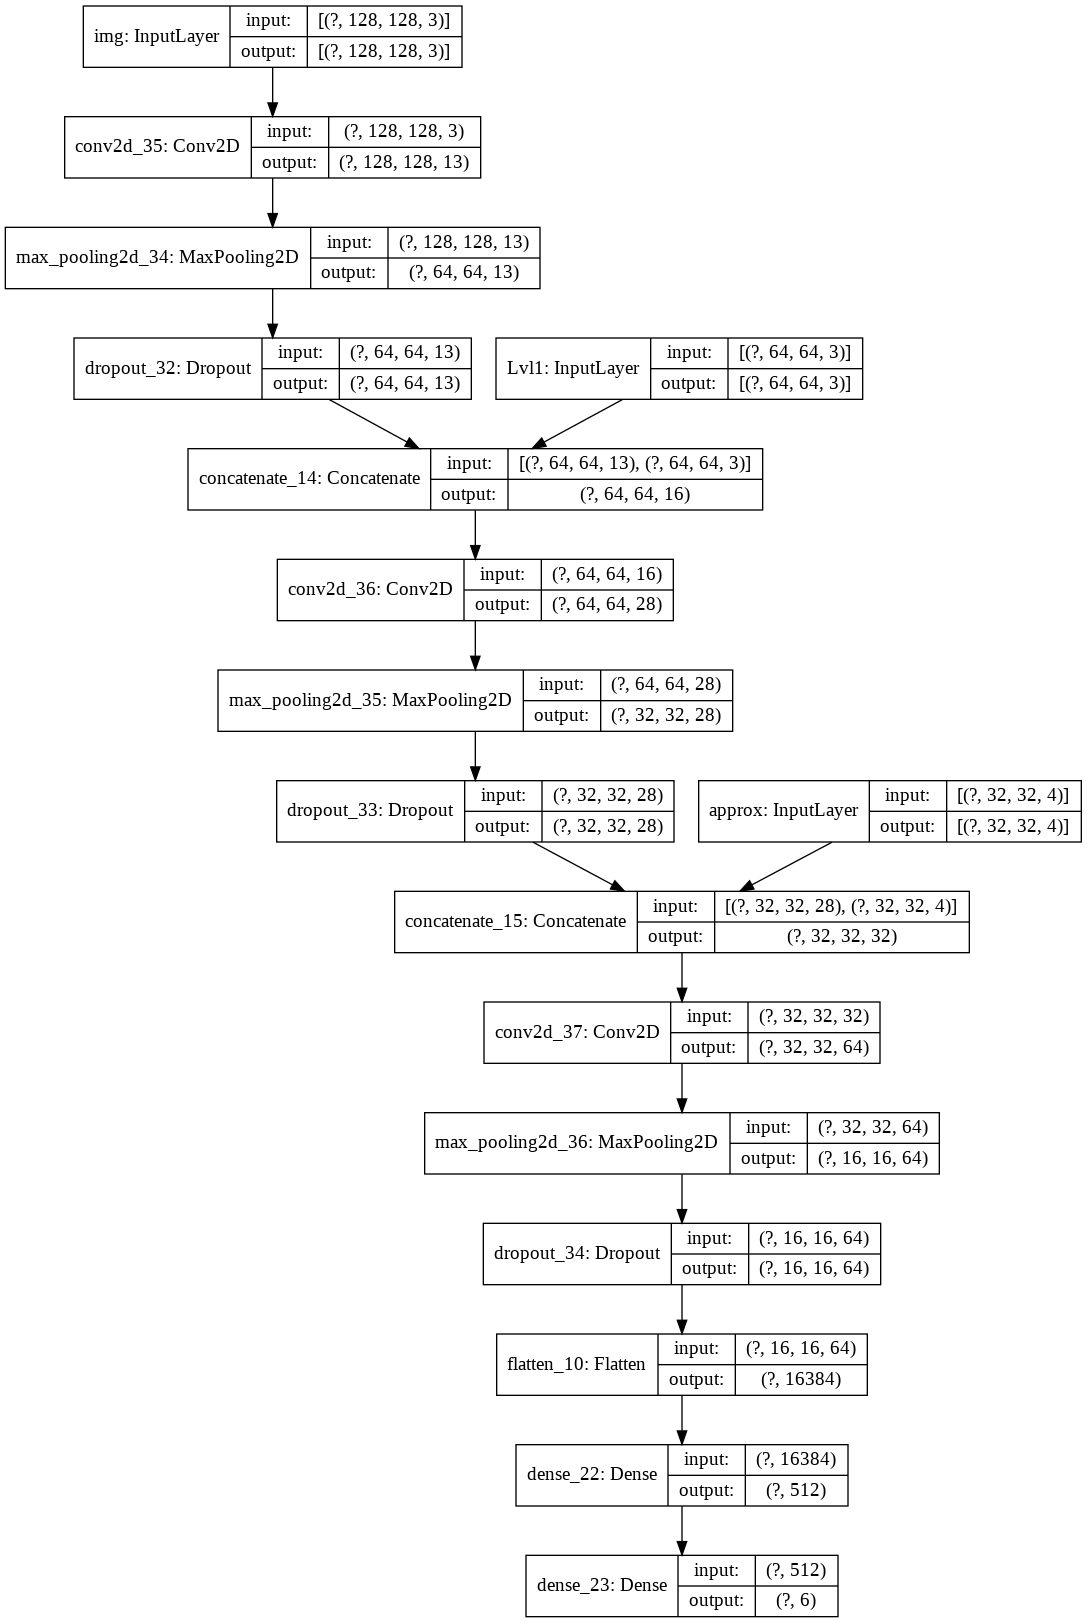

In [0]:
tf.keras.utils.plot_model(mc2, 'multi_input_and_output_model.png', show_shapes=True)

In [0]:
image_batch, label_batch = next(train_data_gen)
wave_batch = waveletize_multilevel(image_batch, level=lvl)
inps = [image_batch]
for i in range(1, lvl+1):
    inps.append(wave_batch[lvl-i])

loss0,accuracy0 = mc2.evaluate(x={'img': inps[0], 'approx': inps[-1], 
 'Lvl1': inps[1]}, y=label_batch, steps = 1)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

50/50 [==============================] - 0s 2ms/sample - loss: 0.7533 - accuracy: 0.8333
initial loss: 0.75
initial accuracy: 0.83


In [0]:
EPOCHS = 20
lvl = 2
losses_m2 = []
accs_m2 = []
durations_m2 = []

In [0]:
try:

    for e in range(EPOCHS):
        starting_time = time.time()
        image_batch, label_batch = next(train_data_gen)
        wave_batch = waveletize_multilevel(image_batch, level=lvl)
        inps = [image_batch]
        for i in range(1, lvl+1):
            inps.append(wave_batch[lvl-i])

        history = mc2.fit(x={'img': inps[0], 'approx': inps[-1], 
                            'Lvl1': inps[1]}, 
                            y=label_batch, initial_epoch=e,
                            epochs=e+1, steps_per_epoch = 10)
        
        losses_m2.append(history.history["loss"][0])
        accs_m2.append(history.history["accuracy"][0])
        durations_m2.append(time.time() - starting_time)
    
except KeyboardInterrupt:
    print("Interrupted.")

Train on 50 samples
50/50 [==============================] - 1s 19ms/sample - loss: 0.7550 - accuracy: 0.8300
Train on 50 samples
Epoch 2/2
50/50 [==============================] - 0s 2ms/sample - loss: 0.7551 - accuracy: 0.8333
Train on 50 samples
Epoch 3/3
50/50 [==============================] - 0s 2ms/sample - loss: 0.7523 - accuracy: 0.8333
Train on 50 samples
Epoch 4/4
50/50 [==============================] - 0s 2ms/sample - loss: 0.7554 - accuracy: 0.8333
Train on 50 samples
Epoch 5/5
50/50 [==============================] - 0s 2ms/sample - loss: 0.7540 - accuracy: 0.8300
Train on 50 samples
Epoch 6/6
50/50 [==============================] - 0s 2ms/sample - loss: 0.7549 - accuracy: 0.8333
Train on 50 samples
Epoch 7/7
50/50 [==============================] - 0s 2ms/sample - loss: 0.7505 - accuracy: 0.8333
Train on 50 samples
Epoch 8/8
50/50 [==============================] - 0s 2ms/sample - loss: 0.7536 - accuracy: 0.8267
Train on 50 samples
Epoch 9/9
50/50 [====================

In [0]:
%%time
image_batch, label_batch = next(test_data_gen)
wave_batch = waveletize_multilevel(image_batch, level=lvl)
inps = [image_batch]
for i in range(1, lvl+1):
    inps.append(wave_batch[lvl-i])

loss_test,accuracy_test = mc2.evaluate(x={'img': inps[0], 'approx': inps[-1], 
 'Lvl1': inps[1]}, y=label_batch)
print("Test loss: {:.2f}".format(loss_test))
print("Test accuracy: {:.2f}".format(accuracy_test))

200/200 [==============================] - 0s 2ms/sample - loss: 0.7520 - accuracy: 0.8333
Test loss: 0.75
Test accuracy: 0.83
CPU times: user 553 ms, sys: 119 ms, total: 672 ms
Wall time: 39.9 s


In [0]:
print("Total training time is {:.2f} minutes.".format(np.sum(np.array(durations_m2))/60))

Total training time is 3.39 minutes.


### Comparison with Multilevel Wavelet transform

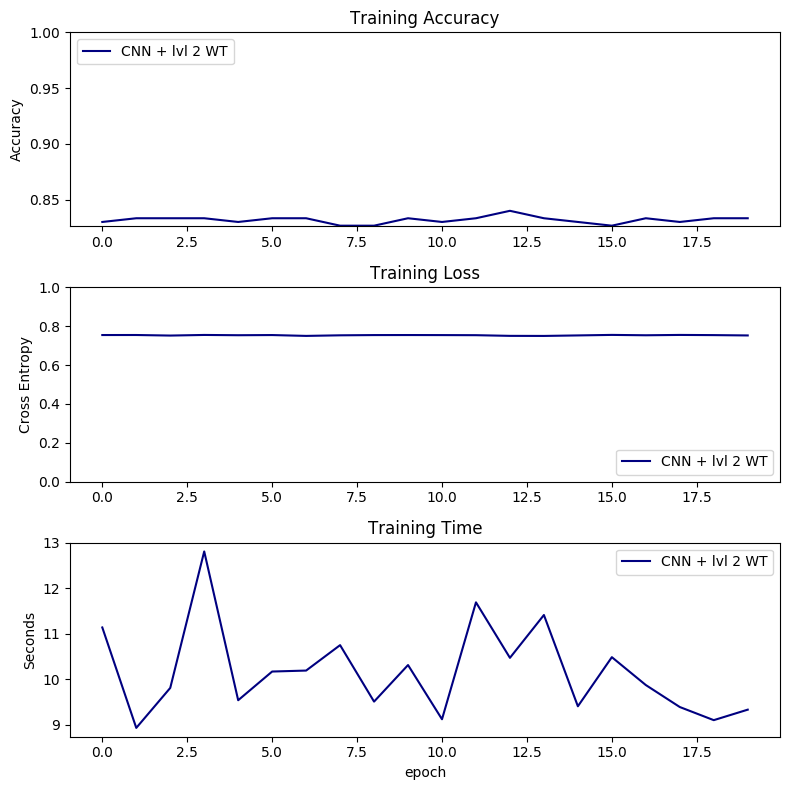

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(accs_0, color = 'coral', label='CNN')
plt.plot(accs, color = 'teal', label='CNN+W')
plt.plot(accs_m2, color = 'navy', label='CNN + lvl 2 WT')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(3, 1, 2)
plt.plot(losses_0, color = 'coral', label='CNN')
plt.plot(losses, color = 'teal', label='CNN+W')
plt.plot(losses_m2, color = 'navy', label='CNN + lvl 2 WT')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')

plt.subplot(3, 1, 3)
plt.plot(durations_0, color = 'coral', label='CNN')
plt.plot(durations, color = 'teal', label='CNN+W')
plt.plot(durations_m2, color = 'navy', label='CNN + lvl 2 WT')
plt.legend(loc='upper right')
plt.ylabel('Seconds')
plt.title('Training Time')
plt.xlabel('epoch')
plt.tight_layout();
plt.show()

## Fatures viz, detection 




In [0]:
layer_outputs = []
for layer in model1.layers:
    print(layer.name)
    layer_outputs.append(layer.output)

conv2d
max_pooling2d
dropout
conv2d_1
max_pooling2d_1
dropout_1
conv2d_2
max_pooling2d_2
dropout_2
flatten
dense
dense_1


In [0]:
# if re.search("(_out)", layer.name)
layer_outputs = [layer.output for layer in model1.layers]
activation_model = tf.keras.models.Model(inputs = model1.input, outputs =  layer_outputs)
activation_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 64, 64, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        592       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0     

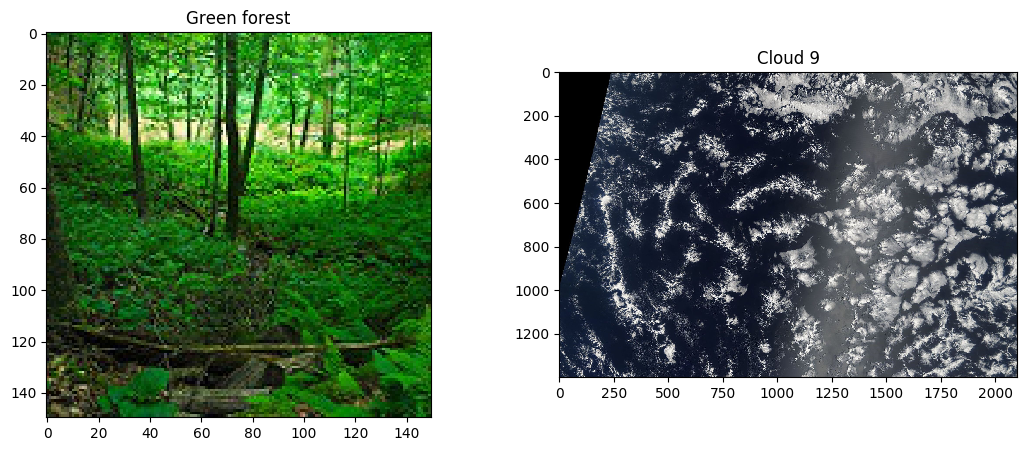

In [0]:
forest_path = 'intel_img/seg_test/forest/20098.jpg'
green_forest = plt.imread(forest_path)

cloud_path = 'clouds/0011165.jpg'
cloud9 = plt.imread(cloud_path)

fig, axs = plt.subplots(1, 2, figsize = (13, 5))
axs[0].set_title("Green forest")
axs[0].imshow(green_forest);

axs[1].set_title("Cloud 9")
axs[1].imshow(cloud9);

In [0]:
def prep_img(filepath):
    image = Image.open(filepath)
    image_resized = np.array(image.resize((128, 128), Image.ANTIALIAS), dtype=float)
    image_resized /= 255.
    
    return image_resized

cloud9 = prep_img(cloud_path)
green_forest = prep_img(forest_path)

In [0]:
green_forest[np.newaxis, :, :, :].shape

(1, 128, 128, 3)

In [0]:
wave_forest = waveletize_batch(green_forest[np.newaxis, :, :, :])
wave_cloud = waveletize_batch(cloud9[np.newaxis, :, :, :])

#### Forest 

In [0]:
activations = activation_model.predict(wave_forest)

In [0]:
activations[0].shape

(1, 64, 64, 16)

In [0]:
total_layers = len(activations)
total_layers

12

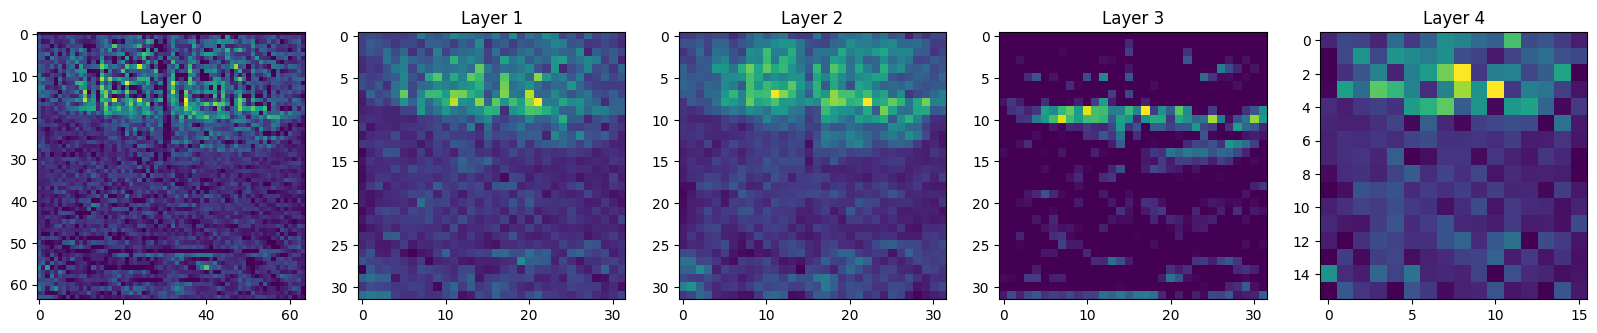

In [0]:
plots_per_layer = 1
n_plots =  5
fig, axs = plt.subplots(1, n_plots, figsize = (n_plots*4, 4))

for i in range(5):
    current_layer = activations[i]
    rp = int(np.random.uniform(0, current_layer.shape[-1]))
    #rp = 0
    axs[i].set_title("Layer {:d}".format(i))
    axs[i].imshow(current_layer[0, :, :, rp], cmap='viridis', interpolation='nearest')

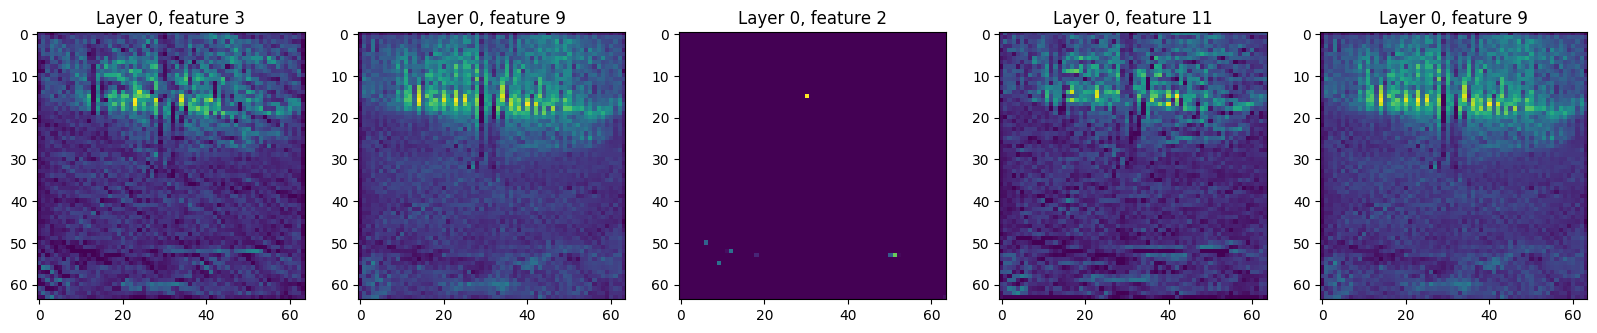

In [0]:
plots_per_layer = 1
n_plots =  5
fig, axs = plt.subplots(1, n_plots, figsize = (n_plots*4, 4))
current_layer = activations[0]

for i in range(n_plots):
    rp = int(np.random.uniform(0, current_layer.shape[-1]))
    axs[i].set_title("Layer {:d}, feature {:d}".format(0, rp))
    axs[i].imshow(current_layer[0, :, :, rp], cmap='viridis', interpolation='nearest')

#### Cloud

In [0]:
activations = activation_model.predict(wave_cloud)

In [0]:
activations[0].shape

(1, 64, 64, 16)

In [0]:
total_layers = len(activations)
total_layers

12

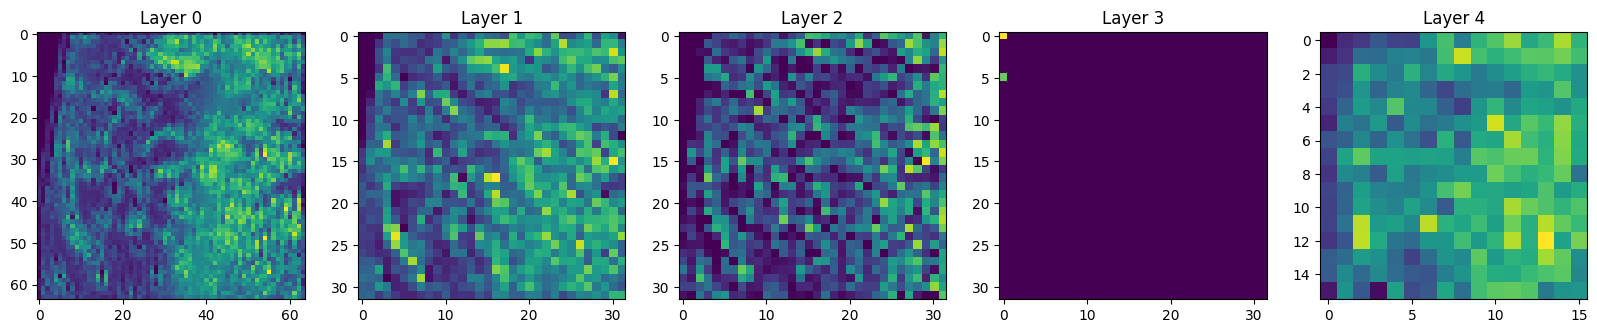

In [0]:
plots_per_layer = 1
n_plots =  5
fig, axs = plt.subplots(1, n_plots, figsize = (n_plots*4, 4))

for i in range(5):
    current_layer = activations[i]
    rp = int(np.random.uniform(0, current_layer.shape[-1]))
    #rp = 0
    axs[i].set_title("Layer {:d}".format(i))
    axs[i].imshow(current_layer[0, :, :, rp], cmap='viridis', interpolation='nearest')

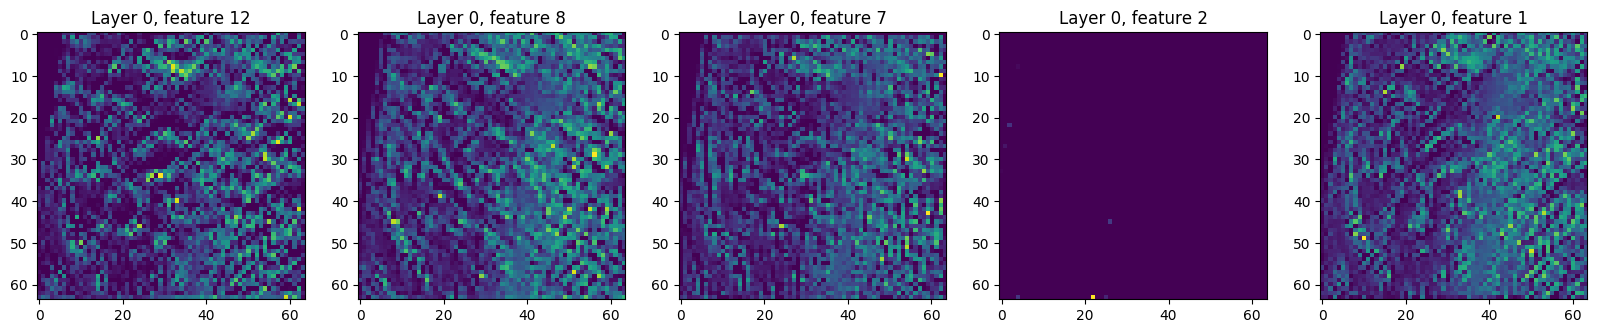

In [0]:
plots_per_layer = 1
n_plots =  5
fig, axs = plt.subplots(1, n_plots, figsize = (n_plots*4, 4))
current_layer = activations[0]

for i in range(n_plots):
    rp = int(np.random.uniform(0, current_layer.shape[-1]))
    axs[i].set_title("Layer {:d}, feature {:d}".format(0, rp))
    axs[i].imshow(current_layer[0, :, :, rp], cmap='viridis', interpolation='nearest')

In [0]:
layer5 = activations[4]
layer5.shape

(1, 16, 16, 32)

In [0]:
layer_names = []
for layer in activation_model.layers:
    layer_names.append(layer.name)

images_per_row = 5

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]

            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize = (scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
